In [1]:
import sys
from pathlib import Path
import numpy as np
import torch

# -------------------------------------------------------------------
# Detect the project root (directory containing src/)
# -------------------------------------------------------------------

# In a notebook, __file__ does NOT exist → use Path.cwd()
CWD = Path.cwd()

PROJECT_ROOT = None
for parent in [CWD, *CWD.parents]:
    if (parent / "src" / "__init__.py").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError(
        f"Could not find project root containing src/. Started search from: {CWD}"
    )

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

# -------------------------------------------------------------------
# Now safe to import project modules
# -------------------------------------------------------------------

from src.config import GridSpec, PMLConfig
from src.ml import (
    SimpleFNO,
    train_model,
    eval_relative_metrics,
    get_freq_dataset,      # re-exported from data.py
    AmpNormWrapper,
    StdNormWrapper,
    compute_input_stats,
)
from src.data import CoordWrapper  # or from src.ml if you re-export it there



PROJECT_ROOT = c:\Users\31624\Documents\MIT\Programming\FreqTransfer


In [2]:
# Grid and PML configuration
grid = GridSpec(
    dims=2,
    shape=(48, 48),
    lengths=(1.0, 1.0),
)
pml_cfg = PMLConfig(thickness=16, m=2, sigma_max=10.0)

# Frequencies
omega_src = 20.0
omega_tgt = 40.0

def omega_to_k(omega: float) -> float:
    c = 1.0
    return omega / c


In [3]:
# Size of the dataset
N_samples = 200

# 1) Load or build the cached freq-transfer dataset (2 channels: Re, Im)
dataset_raw = get_freq_dataset(
    grid=grid,
    pml=pml_cfg,
    omega_src=omega_src,
    omega_tgt=omega_tgt,
    N_samples=N_samples,
    omega_to_k=omega_to_k,
    overwrite=False,  # set True if you change PDE / PML configuration
)

print("Raw dataset length:", len(dataset_raw))
u_src_raw, u_tgt_raw = dataset_raw[0]
print("raw u_src shape:", u_src_raw.shape, "raw u_tgt shape:", u_tgt_raw.shape)

# 2) Wrap with coordinate channels → input becomes (4, H, W)
from src.data import CoordWrapper  # (if not already imported at top)

dataset = CoordWrapper(dataset_raw, grid, normalise=True)

u_in, u_tgt = dataset[0]
print("with coords: input shape:", u_in.shape, "target shape:", u_tgt.shape)


[get_freq_dataset] Loading cached dataset from: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\freq_transfer_cached\wsrc20p000_wtgt40p000_N200_grid48x48_pmlT16_m2_sig10p00
  Loaded N=200 samples, ω_src=20.0, ω_tgt=40.0
Raw dataset length: 200
raw u_src shape: torch.Size([2, 48, 48]) raw u_tgt shape: torch.Size([2, 48, 48])
with coords: input shape: torch.Size([4, 48, 48]) target shape: torch.Size([2, 48, 48])


In [ ]:
# 1) NO per-sample amplitude normalisation for now
# Just use the raw dataset
# dataset_amp = AmpNormWrapper(dataset_raw)  # <- disable this

# 2) Compute stats on the raw inputs
#mean, std = compute_input_stats(dataset_raw, max_samples=200)

# 3) Standardise both u_src and u_tgt
#dataset = StdNormWrapper(dataset_raw, mean, std)


In [4]:
# Infer number of input channels from the final dataset
in_ch = dataset[0][0].shape[0]  # should now be 4
print("Input channels:", in_ch)

model = SimpleFNO(
    in_ch=in_ch,
    width=48,
    modes=(12, 12),
    layers=4,
)
print(model)

epochs = 50
batch_size = 16
lr = 1e-3

model, history = train_model(
    model=model,
    dataset=dataset,        # <- coord-augmented dataset
    epochs=50,
    batch_size=16,
    lr=1e-3,
    val_split=0.2,
    device=None,
    verbose=True,
    loss_type="rel_l2",
)



Input channels: 4
SimpleFNO(
  (proj_in): Conv2d(4, 48, kernel_size=(1, 1), stride=(1, 1))
  (spectral): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (w): ModuleList(
    (0-3): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GELU(approximate='none')
  (proj_out): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
)
[001/50] train=1.9587e+05  val=3.7827e+04
[002/50] train=2.4245e+04  val=1.3212e+04
[003/50] train=7.0346e+03  val=2.9546e+03
[004/50] train=2.2212e+03  val=1.0931e+03
[005/50] train=1.0649e+03  val=1.2082e+03
[006/50] train=9.9762e+02  val=1.0977e+03
[007/50] train=8.1835e+02  val=6.7755e+02
[008/50] train=6.4835e+02  val=7.0204e+02
[009/50] train=5.6568e+02  val=4.3178e+02
[010/50] train=5.0305e+02  val=4.5708e+02
[011/50] train=3.7141e+02  val=6.9394e+02
[012/50] train=3.9519e+02  val=6.3713e+02
[013/50] train=5.5255e+02  val=1.2476e+02
[014/50] train=4.3440e+02  val=4.2298e+02
[015/50] train=3.7079e+02  val=2.4898e+02
[016/50] train=3.1979e+02  val

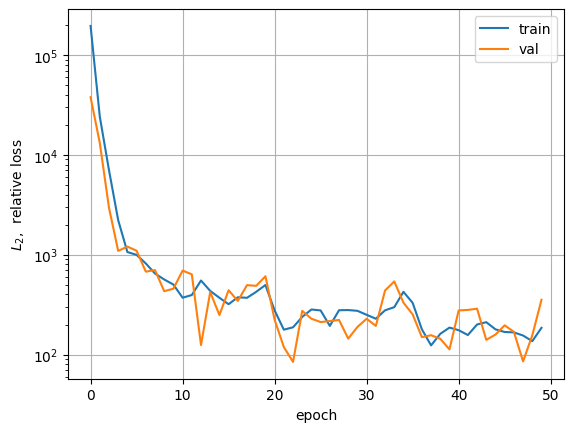

{'rel_L2_mean': 364.97863487243654,
 'rel_L2_median': 334.6658935546875,
 'rel_L2_p90': 559.4682983398437,
 'mag_RMSE': 0.008937243756329503,
 'phase_RMSE': 1.8138359468727543}

In [ ]:
from matplotlib import pyplot as plt

plt.semilogy(history["train"], label="train")
plt.semilogy(history["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("$L_2$ relative loss")
plt.legend()
plt.grid(True)
plt.show()

metrics = eval_relative_metrics(model, dataset, batch_size=16)
metrics



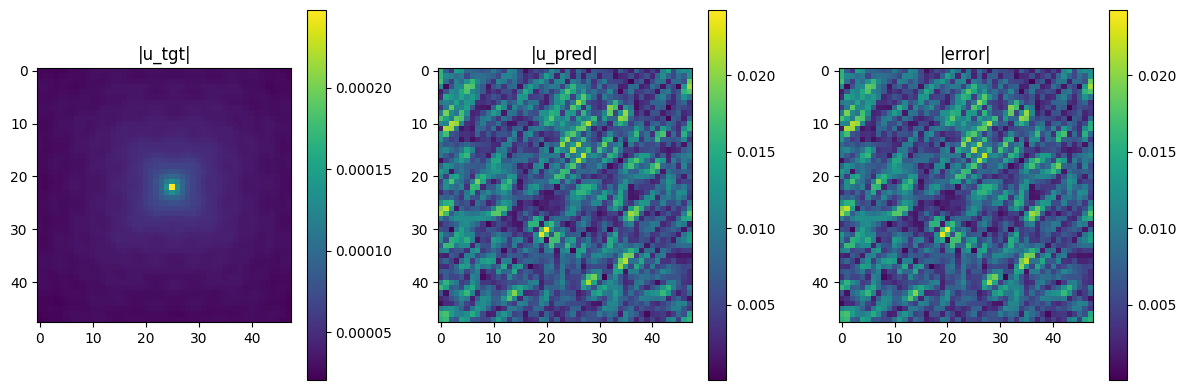

In [10]:
# Pick a sample
idx = 0
u_src_n, u_tgt_n = dataset[idx]

model.eval()
with torch.no_grad():
    pred_n = model(u_src_n.unsqueeze(0)).squeeze(0)  # (2,H,W)

u_tgt = u_tgt_n.numpy()
u_pred = pred_n.numpy()

def to_complex(two_ch):
    return two_ch[0] + 1j * two_ch[1]

u_tgt_c = to_complex(u_tgt)
u_pred_c = to_complex(u_pred)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im0 = axes[0].imshow(np.abs(u_tgt_c)); axes[0].set_title("|u_tgt|"); plt.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(np.abs(u_pred_c)); axes[1].set_title("|u_pred|"); plt.colorbar(im1, ax=axes[1])
im2 = axes[2].imshow(np.abs(u_pred_c - u_tgt_c)); axes[2].set_title("|error|"); plt.colorbar(im2, ax=axes[2])
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import torch

def rel_l2_numpy(a, b, eps=1e-12):
    return np.linalg.norm(a - b) / (np.linalg.norm(b) + eps)

# predictor 1: u_pred = 0
rels_zero = []
for i in range(len(dataset)):
    x, y = dataset[i]            # x: (4,H,W) or (2,H,W), y: (2,H,W)
    y_np = y.numpy()
    u_pred_zero = np.zeros_like(y_np)
    rels_zero.append(rel_l2_numpy(u_pred_zero, y_np))
print("baseline u_pred=0: mean rel L2 =", np.mean(rels_zero))

# predictor 2: u_pred = u_src (first 2 channels)
rels_copy = []
for i in range(len(dataset)):
    x, y = dataset[i]
    y_np = y.numpy()
    u_pred_copy = x[:2].numpy()   # assume first 2 ch are Re/Im(u_src)
    rels_copy.append(rel_l2_numpy(u_pred_copy, y_np))
print("baseline u_pred=u_src: mean rel L2 =", np.mean(rels_copy))


baseline u_pred=0: mean rel L2 = 1.0
baseline u_pred=u_src: mean rel L2 = 1.6646473


In [ ]:
from src.ml import build_direct_map, SimpleFNO, train_model, eval_relative_metrics

direct_ds = build_direct_map(
    n=200,
    grid=grid,
    k_range=(20.0, 20.0),  # fixed k for now
    include_k_channel=False,
    seed=0,
)

in_ch = direct_ds[0][0].shape[0]
model_direct = SimpleFNO(in_ch=in_ch, width=48, modes=(12,12), layers=4)

model_direct, hist_direct = train_model(
    model_direct,
    direct_ds,
    epochs=50,
    batch_size=16,
    lr=1e-3,
    val_split=0.2,
    loss_type="rel_l2",
)
metrics_direct = eval_relative_metrics(model_direct, direct_ds, batch_size=16)
print(metrics_direct)


[001/50] train=4.1230e+04  val=1.4170e+04
[002/50] train=5.7515e+03  val=1.9667e+03
[003/50] train=1.4340e+03  val=8.3268e+02
[004/50] train=7.4771e+02  val=3.4395e+02
[005/50] train=2.9917e+02  val=1.7258e+02
[006/50] train=1.6529e+02  val=1.1054e+02
[007/50] train=1.0209e+02  val=5.3981e+01
[008/50] train=9.1008e+01  val=1.6037e+02
[009/50] train=1.9562e+02  val=1.5835e+02
[010/50] train=1.8426e+02  val=1.6367e+02
[011/50] train=1.5337e+02  val=1.2086e+02
[012/50] train=1.0617e+02  val=8.1681e+01
[013/50] train=6.2885e+01  val=8.3110e+01
[014/50] train=7.0450e+01  val=4.8294e+01
[015/50] train=4.4608e+01  val=5.7288e+01
[016/50] train=6.3798e+01  val=2.6894e+01
[017/50] train=9.1885e+01  val=1.1549e+02
[018/50] train=7.7374e+01  val=4.4315e+01
[019/50] train=6.9367e+01  val=6.8619e+01
[020/50] train=7.3196e+01  val=5.8386e+01
[021/50] train=5.3108e+01  val=2.8187e+01
[022/50] train=5.3481e+01  val=5.0308e+01
[023/50] train=5.2217e+01  val=3.5695e+01
[024/50] train=5.2354e+01  val=4.4